In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc)
from sklearn.neighbors import NearestCentroid
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [44]:
## Import data from Kaggle loans info
data = pd.read_csv('Loan_default.csv')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [46]:
data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [47]:
# It is a rather large dataset (+24MB), will subset data to n=3000 random_samples for easier uploading  



data = data.sample(n=3000, random_state=42).copy()
data = data.copy()

In [48]:
# Separate features (X) and target variable (y)
#ID is just a unique tag per loan, irrelavent 

X = data.drop(['Default', 'LoanID'], axis=1)
y = data['Default']

In [49]:
# Because we are trying to find the most significant correlations with another categorical variable ('Default'),
# it is very important to ensure we encode our categorical to ensure accurate feature selection. 
# One-hot encode all object (categorical) columns
X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)

In [50]:
rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)
rf_regressor.fit(X_encoded, y)
feature_importances = rf_regressor.feature_importances_

In [51]:
importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)



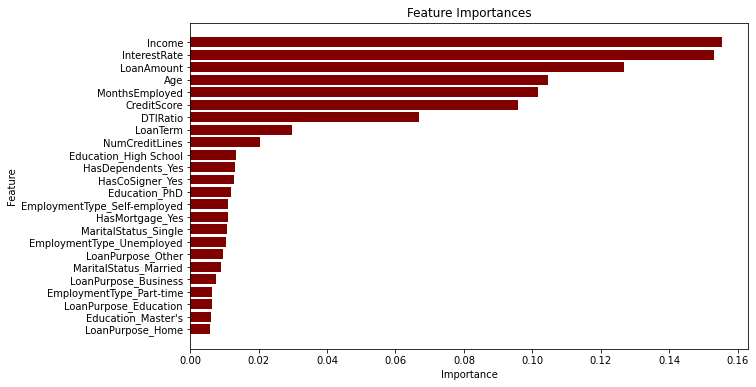

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='maroon')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()

In [53]:
# Choosing Features with importance > 0.03

In [54]:
X = data[['InterestRate', 'Income', 'LoanAmount', 'Age', 'CreditScore',
          'MonthsEmployed', 'DTIRatio', 'LoanTerm', 'NumCreditLines']]
y = data['Default']

In [55]:
# The classes are unbalanced and will heavily skew the results. This MUST be addressed in order to accurately predict our target 'Default' variable.
# Applying Synthetic Minority Over-Sampling Technique SMOTE

In [56]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [57]:
y_resampled.value_counts(normalize=True)


Default
0    0.5
1    0.5
Name: proportion, dtype: float64

In [58]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [59]:

classifiers = {    
    'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42, probability=True),  # Enable probability estimates
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(n_estimators=10, random_state=42),
    
}

# Initialize dictionaries to store evaluation metric results
results = {
    'Classifier': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC': []
}



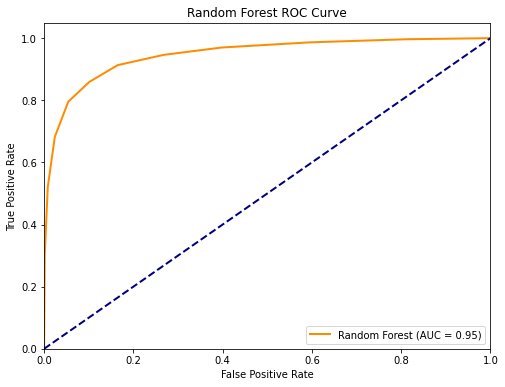

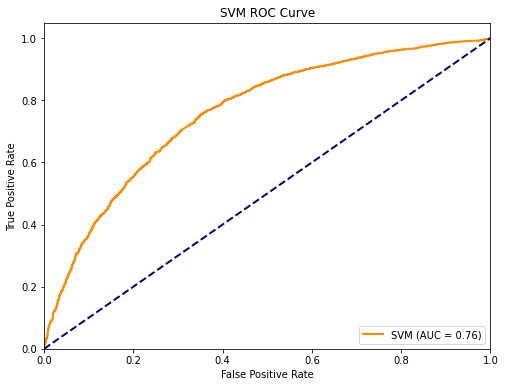

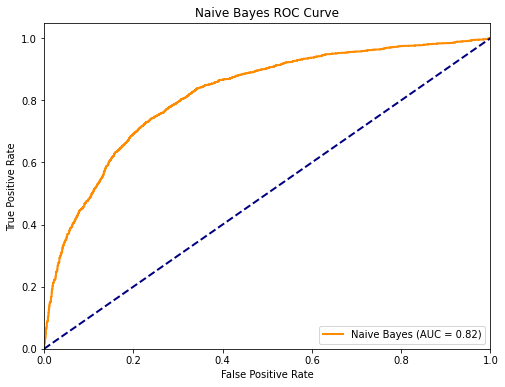

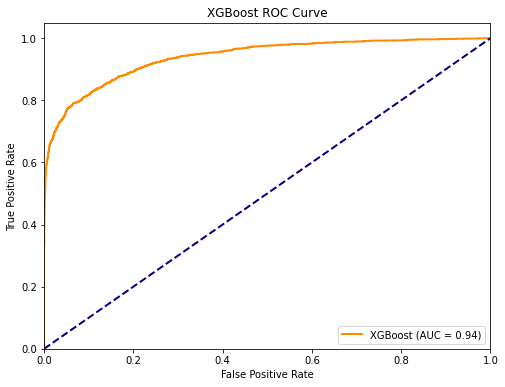

In [60]:
# Loop through classifiers and calculate various evaluation metrics using cross-validation
for classifier_name, classifier in classifiers.items():
    y_scores = cross_val_predict(classifier, X_scaled, y_resampled, cv=5, method='predict_proba')[:, 1]
    
    accuracy_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='accuracy')
    f1_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='f1')
    precision_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='precision')
    recall_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='recall')
    roc_auc_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='roc_auc')
    
    # Take the mean of cross-validation scores
    accuracy_mean = np.mean(accuracy_scores)
    f1_mean = np.mean(f1_scores)
    precision_mean = np.mean(precision_scores)
    recall_mean = np.mean(recall_scores)
    roc_auc_mean = np.mean(roc_auc_scores)
    
    results['Classifier'].append(classifier_name)
    results['Accuracy'].append(accuracy_mean)
    results['F1 Score'].append(f1_mean)
    results['Precision'].append(precision_mean)
    results['Recall'].append(recall_mean)
    results['ROC AUC'].append(roc_auc_mean)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_resampled, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{classifier_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

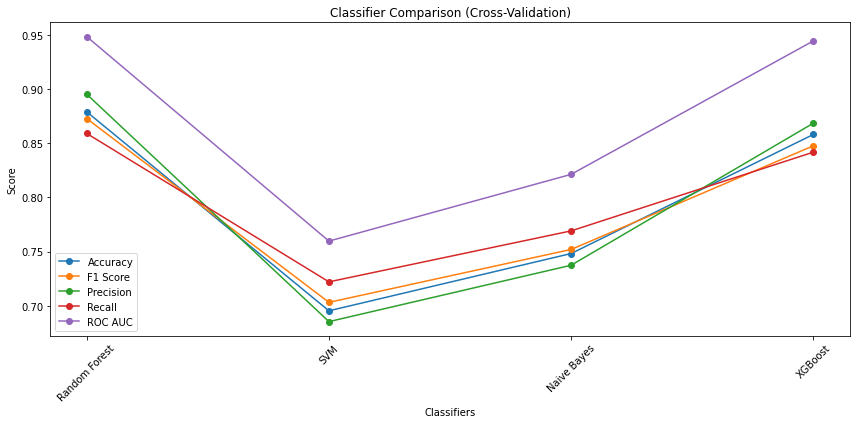

In [61]:

    

# Create line plots to compare evaluation metrics
plt.figure(figsize=(12, 6))
for metric_name, metric_results in {
    'Accuracy': results['Accuracy'],
    'F1 Score': results['F1 Score'],
    'Precision': results['Precision'],
    'Recall': results['Recall'],
    'ROC AUC': results['ROC AUC']
}.items():
    plt.plot(results['Classifier'], metric_results, label=metric_name, marker='o')

plt.xlabel('Classifiers')
plt.ylabel('Score')
plt.title('Classifier Comparison (Cross-Validation)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
    

In [62]:
results_df = pd.DataFrame(results)
print(results_df)

      Classifier  Accuracy  F1 Score  Precision    Recall   ROC AUC
0  Random Forest  0.878912  0.872709   0.895145  0.858987  0.948307
1            SVM  0.695372  0.703183   0.685394  0.722084  0.759678
2    Naive Bayes  0.748217  0.751977   0.737408  0.769104  0.821262
3        XGBoost  0.858042  0.847566   0.868429  0.841709  0.944328
